# Задача: Отобразить высокомерные данные $X ∈ ℝ^D$ в низкомерное пространство $Y ∈ ℝ^d (d=2,3)$ так, чтобы сохранить структуру соседства.

    1. Вероятностная постановка задачи


Задача: Отобразить высокомерные данные $X ∈ ℝ^D$ в низкомерное пространство $Y ∈ ℝ^d (d=2,3)$
так, чтобы сохранить структуру соседства.


        - Вероятности в исходном пространстве

Гауссово ядро для измерения сходства:

$
p_{j|i} = exp(-||x_i - x_j||^2 / (2σ_i^2)) / Σ_{k≠i} exp(-||x_i - x_k||^2 / (2σ_i^2))$

Симметризация вероятностей:

$
p_{ij} = (p_{j|i} + p_{i|j}) / (2n)$

Перплексия (perplexity) как гиперпараметр:

$
Perp(P_i) = 2^{H(P_i)}, $

где $H(P_i) = -Σ_j p_{j|i} log₂ p_{j|i}$

        - Вероятности в целевом пространстве

Распределение Стьюдента с одной степенью свободы:

$
q_{ij} = (1 + ||y_i - y_j||^2)^{-1} / Σ_{k≠l} (1 + ||y_k - y_l||^2)^{-1}$

Преимущества t-распределения:

       * Тяжелые хвосты

       * Устойчивость к проклятию размерности

       * Улучшенное разделение кластеров

       * Функция стоимости (KL-дивергенция)

$C(Y) = KL(P||Q) = Σ_i Σ_j p_{ij} log(p_{ij} / q_{ij})$

    2. Оптимизация функции стоимости

        2.1. Градиент функции стоимости

$∂C/∂y_i = 4 Σ_j (p_{ij} - q_{ij})(y_i - y_j)(1 + ||y_i - y_j||^2)^{-1}$

       2.2. Методы оптимизации

Градиентный спуск с моментумом:

$Y^{(t)} = Y^{(t-1)} + η ∂C/∂Y + α(t)(Y^{(t-1)} - Y^{(t-2)})$


Раннее преувеличение (early exaggeration):


$p_{ij} ← p_{ij} × 4 (первые 100 итераций)$


Адаптивное обучение (adaptive learning rate)

        2.3. Сложности оптимизации

            - Невыпуклость функции стоимости

            - Локальные минимумы

            - Чувствительность к начальной инициализации

            - Вычислительная сложность O(n²)

Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Задание

1. Провести исследование влияния гиперпараметров на результаты кластеризации с T-SNE
2. Сравнить с PCA
   
Использовать 2 датасета - стандартного типа Ирис или Цифры, и своего. Не забываем про нормировку и eda в целом

=== ИРИС ДАТАСЕТ ===
Размер данных: (150, 4)
Количество классов: 3
Имена признаков: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Имена классов: ['setosa' 'versicolor' 'virginica']

Статистика по признакам:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%           

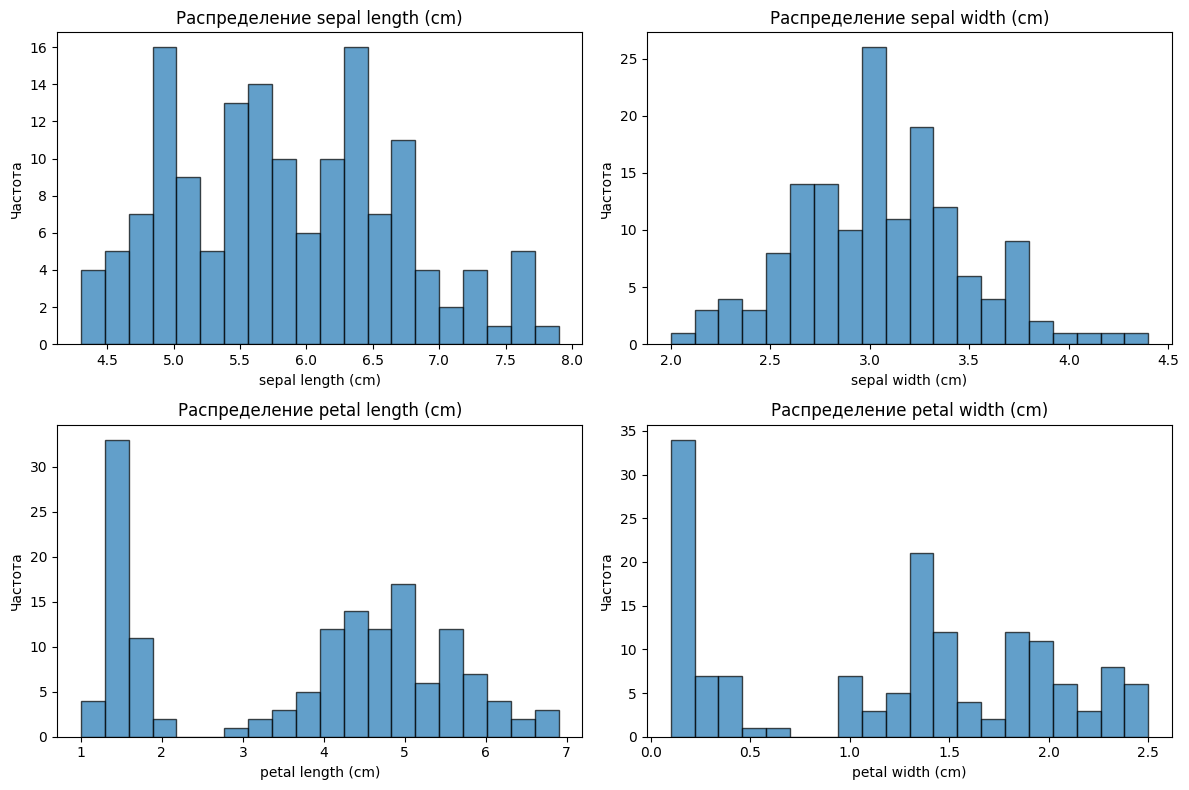

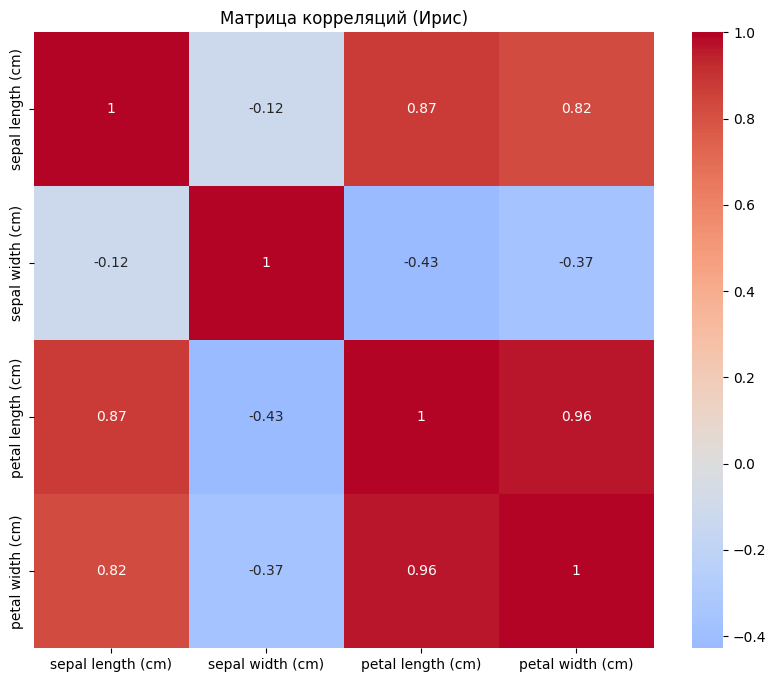

In [6]:
from sklearn import datasets

# Загрузка датасета Ирис
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names_iris = iris.feature_names
target_names_iris = iris.target_names

print("=== ИРИС ДАТАСЕТ ===")
print(f"Размер данных: {X_iris.shape}")
print(f"Количество классов: {len(np.unique(y_iris))}")
print(f"Имена признаков: {feature_names_iris}")
print(f"Имена классов: {target_names_iris}")
print(f"\nСтатистика по признакам:")
iris_df = pd.DataFrame(X_iris, columns=feature_names_iris)
print(iris_df.describe())

# Визуализация распределения признаков
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for idx, feature in enumerate(feature_names_iris):
    ax = axes[idx//2, idx%2]
    ax.hist(X_iris[:, idx], bins=20, alpha=0.7, edgecolor='black')
    ax.set_xlabel(feature)
    ax.set_ylabel('Частота')
    ax.set_title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

# Матрица корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(iris_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций (Ирис)')
plt.show()

In [7]:
from sklearn.datasets import load_digits

# 1. Загрузка данных
digits = load_digits()
X = digits.data
y = digits.target

Разделить выборку на фичи и целевую переменную

In [9]:
feature_cols = [f'pixel_{i}_{j}' for i in range(8) for j in range(8)]
X = pd.DataFrame(X, columns=feature_cols)
y = pd.Series(y, name='digit')

print(X.shape, y.shape)

(1797, 64) (1797,)


Нормировка

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)

Доля объяснённой дисперсии: [0.12033916 0.09561054] Суммарно: 0.21594970500832786


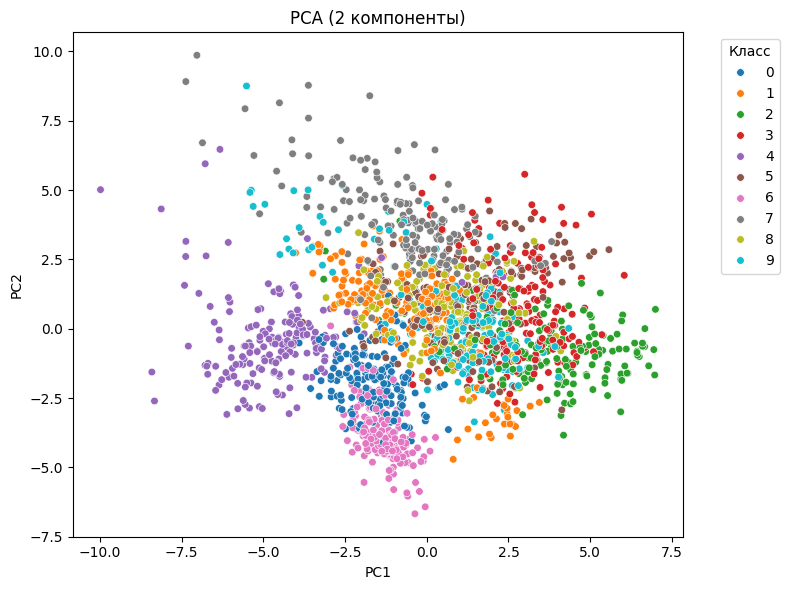

In [11]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Доля объяснённой дисперсии:", pca.explained_variance_ratio_,
      "Суммарно:", sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="tab10", s=30)
plt.title("PCA (2 компоненты)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

TSNE 2 компоненты

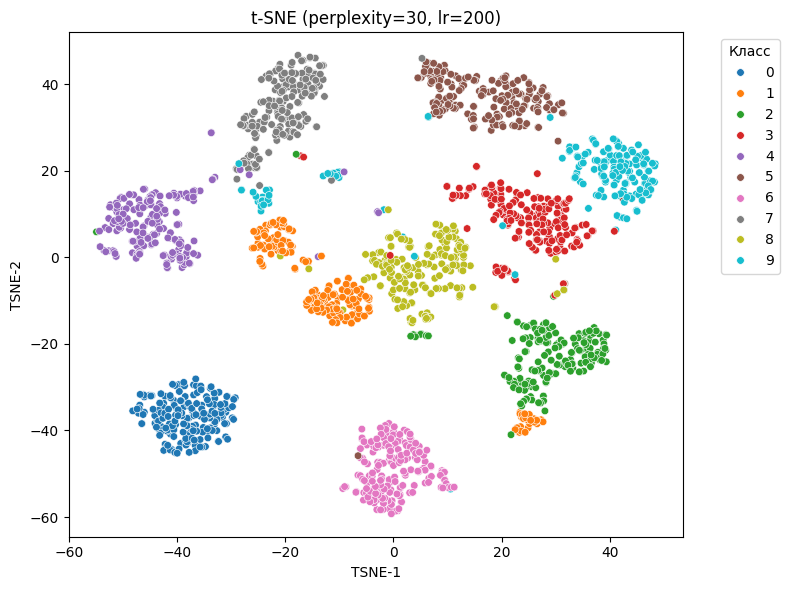

In [12]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="tab10", s=30)
plt.title("t-SNE (perplexity=30, lr=200)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import pairwise_distances

def separation_score(X_2d, y):
    y_array = np.array(y)
    D = pairwise_distances(X_2d)
    same = D[y_array[:, None] == y_array[None, :]]
    diff = D[y_array[:, None] != y_array[None, :]]
    return same.mean(), diff.mean(), diff.mean() / same.mean()

pca_same, pca_diff, pca_ratio = separation_score(X_pca, y)
tsne_same, tsne_diff, tsne_ratio = separation_score(X_tsne, y)

print("PCA:  среднее расстояние внутри класса =", pca_same,
      ", между классами =", pca_diff,
      ", ratio =", pca_ratio)
print("t-SNE: среднее расстояние внутри класса =", tsne_same,
      ", между классами =", tsne_diff,
      ", ratio =", tsne_ratio)


PCA:  среднее расстояние внутри класса = 2.468234399163823 , между классами = 4.761456156687811 , ratio = 1.9290939945982744
t-SNE: среднее расстояние внутри класса = 13.243143 , между классами = 54.21295 , ratio = 4.093662


Вычислить и отрисовать T-SNE с разным значением Perplexity

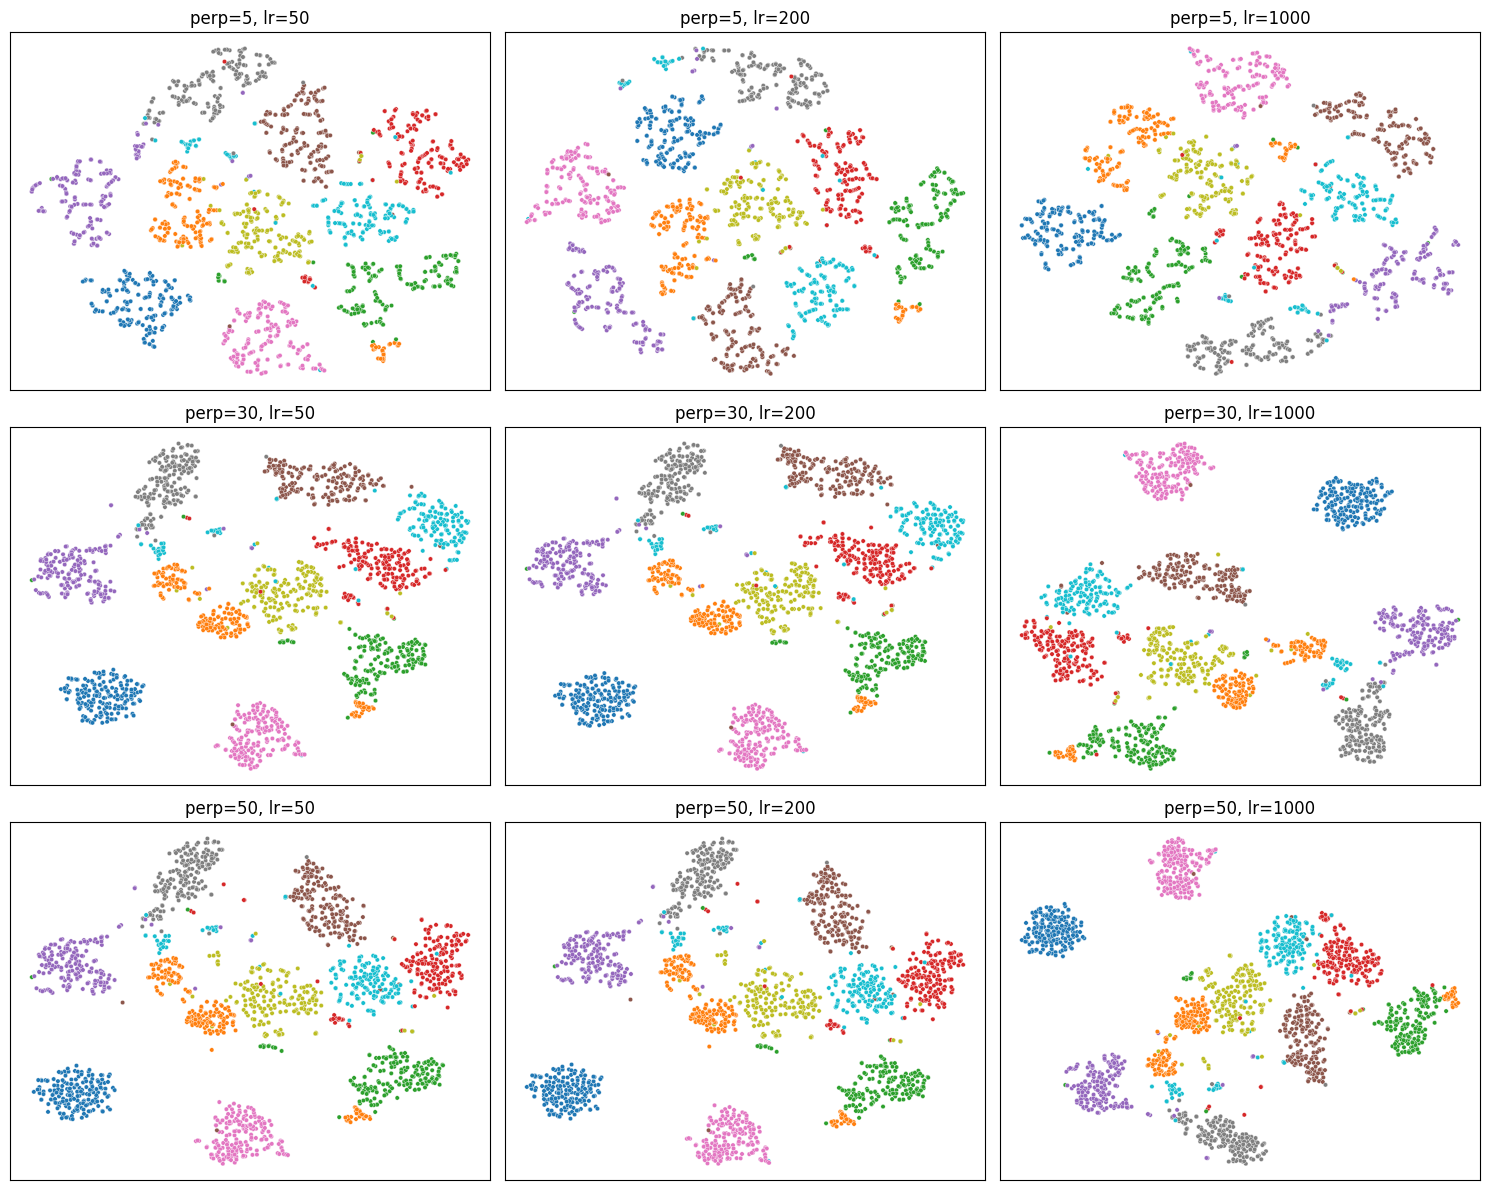

In [18]:
perplexities = [5, 30, 50]
learning_rates = [50, 200, 1000]

fig, axes = plt.subplots(len(perplexities), len(learning_rates),
                         figsize=(5*len(learning_rates), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(
            n_components=2,
            perplexity=perp,
            learning_rate=lr,
            random_state=42
        )
        X_emb = tsne.fit_transform(X_scaled)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1],
                        hue=y, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"perp={perp}, lr={lr}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

Проанализируйте:

как меняется форма кластеров,

возникают ли “разрывы” или слияния при разных параметрах,

насколько стабилен рисунок при небольших изменениях параметров.

PCA: устойчивая структура
Для PCA параметров немного (по сути только число компонент), проекция при фиксированном random_state практически не меняется, что показывает устойчивость метода.

Можно показать, что при разных n_components (2, 3, больше) первые две компоненты остаются близкими, а общая структура мало меняется.

In [20]:
pca_10 = PCA(n_components=10, random_state=42)
X_pca_10 = pca_10.fit_transform(X_scaled)

print("Суммарная объяснённая дисперсия (10 компонент):",
      pca_10.explained_variance_ratio_.sum())


Суммарная объяснённая дисперсия (10 компонент): 0.5887375533730295
